In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shapely pyclipper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install -q -U albumentations
!pip install -q opencv-python matplotlib numpy

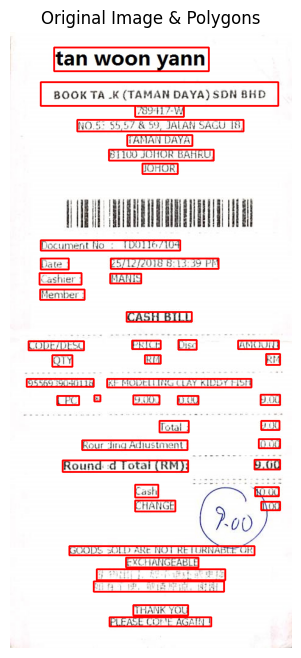

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def load_sroie_sample(image_path, txt_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot find image at {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    polygons = []
    try:
        with open(txt_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 9:
                    coords = [int(p) for p in parts[:8]]
                    poly = np.array(coords).reshape(4, 2)
                    polygons.append(poly)
    except FileNotFoundError:
        print(f"Warning: No label file found at {txt_path}")

    return img_rgb, polygons

def draw_polygons(image, polygons, color=(255, 0, 0), thickness=2):
    """Helper to draw polygons on an image."""
    img_copy = image.copy()
    for poly in polygons:
        cv2.polylines(img_copy, [poly.astype(np.int32)], isClosed=True, color=color, thickness=thickness)
    return img_copy

SAMPLE_IMG = '/content/drive/MyDrive/0325updated.task1train(626p)/X00016469612.jpg'
SAMPLE_TXT = '/content/drive/MyDrive/0325updated.task1train(626p)/X00016469612.txt'

orig_img, orig_polys = load_sroie_sample(SAMPLE_IMG, SAMPLE_TXT)

plt.figure(figsize=(8, 8))
plt.imshow(draw_polygons(orig_img, orig_polys))
plt.title("Original Image & Polygons")
plt.axis('off')
plt.show()

In [ ]:
#Test Augmentation

In [ ]:
##Photometric Transformations

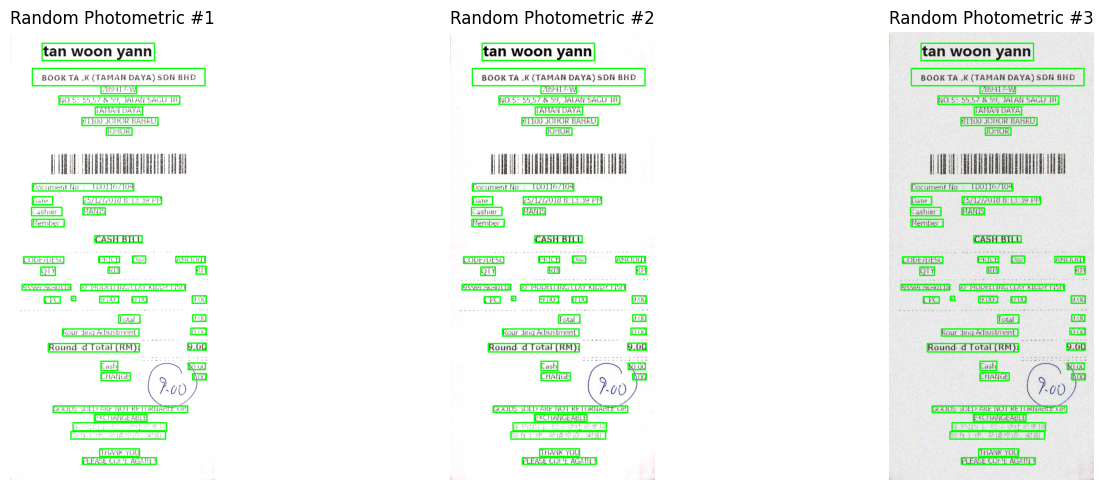

In [ ]:

def random_photometric(image):
    """
    Randomly applies brightness, contrast, blur, and noise.
    Returns the augmented image (Polygons remain unchanged).
    """
    img = image.copy()

    #  Color Jitter (Brightness & Contrast) - 50% chance
    if random.random() > 0.5:
        # alpha controls contrast (0.7 to 1.3)
        alpha = random.uniform(0.7, 1.3)
        # beta controls brightness (-30 to 30)
        beta = random.uniform(-30, 30)
        # Formula: new_pixel = alpha * old_pixel + beta
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    #  Motion Blur / Gaussian Blur - 30% chance
    if random.random() > 0.7:
        # Using a 5x5 kernel to simulate slight camera out-of-focus
        img = cv2.GaussianBlur(img, (5, 5), 0)

    # Image Noise (Simulating cheap camera sensor) - 30% chance
    if random.random() > 0.7:
        # Generate random noise map
        noise = np.random.randint(0, 40, img.shape, dtype='uint8')
        # Add noise to image (cv2.add prevents values going over 255)
        img = cv2.add(img, noise)

    return img
plt.figure(figsize=(15, 5))
for i in range(3):
    aug_img = random_photometric(orig_img)
    drawn_img = draw_polygons(aug_img, orig_polys, color=(0, 255, 0)) # Vẽ khung xanh lá

    plt.subplot(1, 3, i + 1)
    plt.imshow(drawn_img)
    plt.title(f"Random Photometric #{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
##Random rotation

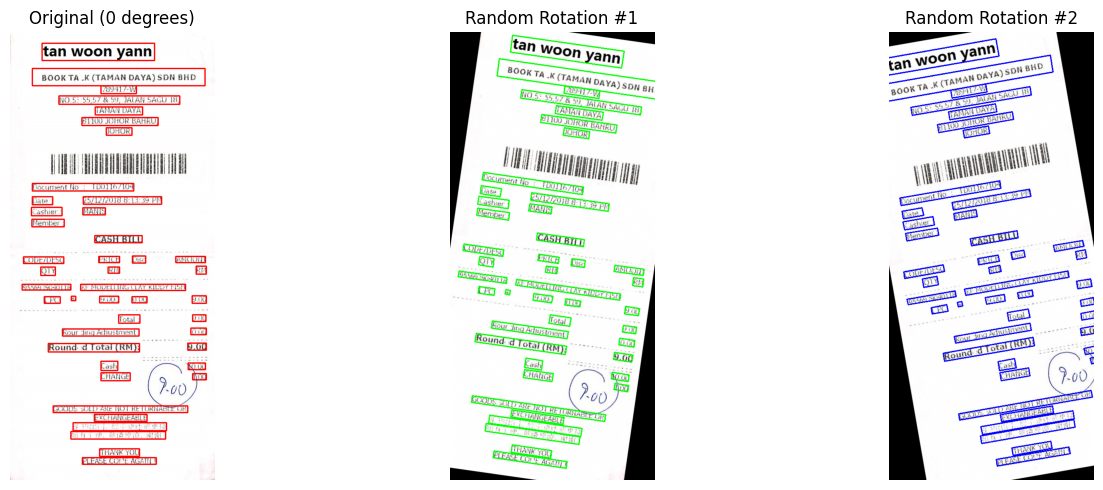

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def random_rotate(image, polygons, max_angle=10):
    h, w = image.shape[:2]

    # 1. Define the center of rotation (middle of the image)
    center = (w / 2, h / 2)

    # 2. Generate a random angle between [-max_angle, max_angle]
    angle = random.uniform(-max_angle, max_angle)

    # If the angle is too small, skip rotation to save computation
    if abs(angle) < 1.0:
        return image, polygons

    # 3. Get the 2x3 Affine Rotation Matrix from OpenCV
    # M = [[cos(theta), -sin(theta), tx],
    #      [sin(theta),  cos(theta), ty]]
    M = cv2.getRotationMatrix2D(center, angle, scale=1.0)

    # 4. Rotate the Image
    # borderValue=(0, 0, 0) fills the newly exposed background corners with black
    rotated_img = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(0, 0, 0))

    # 5. Rotate ALL Polygons mathematically
    rotated_polygons = []
    for poly in polygons:
        new_poly = []
        for point in poly:
            x, y = point
            # Matrix multiplication to find the new (x', y')
            # x' = M[0,0]*x + M[0,1]*y + M[0,2]
            # y' = M[1,0]*x + M[1,1]*y + M[1,2]
            new_x = M[0, 0] * x + M[0, 1] * y + M[0, 2]
            new_y = M[1, 0] * x + M[1, 1] * y + M[1, 2]

            new_poly.append([new_x, new_y])

        # Convert back to float32 numpy array
        rotated_polygons.append(np.array(new_poly, dtype=np.float32))

    return rotated_img, rotated_polygons
# Assuming 'orig_img' and 'orig_polys' are still in memory from Cell 1
plt.figure(figsize=(15, 5))

# Original for comparison
plt.subplot(1, 3, 1)
plt.imshow(draw_polygons(orig_img, orig_polys, color=(255, 0, 0)))
plt.title("Original (0 degrees)")
plt.axis('off')

# Rotate roughly +10 degrees (Counter-clockwise)
rot_img_1, rot_polys_1 = random_rotate(orig_img, orig_polys, max_angle=10)
plt.subplot(1, 3, 2)
plt.imshow(draw_polygons(rot_img_1, rot_polys_1, color=(0, 255, 0)))
plt.title("Random Rotation #1")
plt.axis('off')

# Rotate roughly -10 degrees (Clockwise)
rot_img_2, rot_polys_2 = random_rotate(orig_img, orig_polys, max_angle=10)
plt.subplot(1, 3, 3)
plt.imshow(draw_polygons(rot_img_2, rot_polys_2, color=(0, 0, 255)))
plt.title("Random Rotation #2")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
##Safe Random Crop

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import shapely.geometry # Import toàn bộ thư viện để gọi tường minh

def safe_random_crop(image, polygons, crop_size=(640, 640), max_tries=50):
    """
    Attempts to crop a random region of the image safely.
    Fixed naming collision by explicitly using shapely.geometry.box
    """
    h, w = image.shape[:2]
    crop_w, crop_h = crop_size

    if h <= crop_h or w <= crop_w:
        return image, polygons

    # Use shapely.geometry explicitly
    shapely_polys = [shapely.geometry.Polygon(p) for p in polygons if shapely.geometry.Polygon(p).is_valid]

    for _ in range(max_tries):
        x_min = random.randint(0, w - crop_w)
        y_min = random.randint(0, h - crop_h)
        x_max = x_min + crop_w
        y_max = y_min + crop_h

        # Explicit call to prevent collision with local variables named 'box'
        crop_box = shapely.geometry.box(x_min, y_min, x_max, y_max)

        collision = False
        kept_polygons = []

        for i, poly in enumerate(shapely_polys):
            if not crop_box.intersects(poly):
                continue

            if not crop_box.contains(poly):
                collision = True
                break

            shifted_poly = polygons[i] - np.array([x_min, y_min])
            kept_polygons.append(shifted_poly)

        if not collision:
            cropped_img = image[y_min:y_max, x_min:x_max]
            return cropped_img, kept_polygons

    return image, polygons

print("Fixed Safe Crop Function Ready!")

Fixed Safe Crop Function Ready!


In [ ]:
##Label Generation - Shrink Map

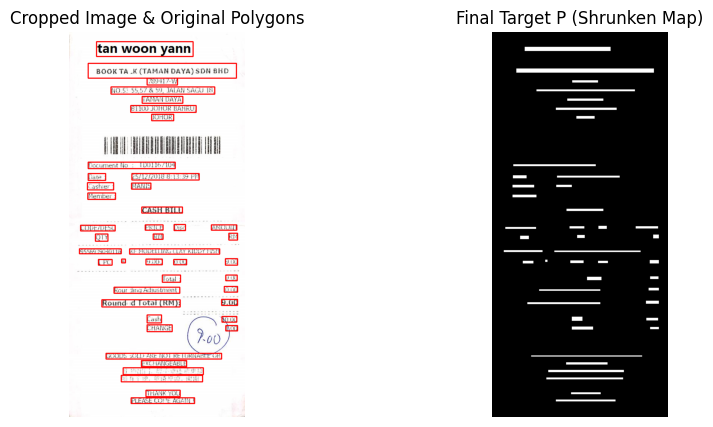

In [ ]:
# LABEL GENERATION
def shrink_polygon_math(poly_coords, shrink_ratio=0.4):
    """
    Shrinks the polygon to create separation between close text lines.
    Formula: D = Area * (1 - r^2) / Perimeter
    """
    polygon = Polygon(poly_coords)
    if not polygon.is_valid or polygon.is_empty:
        return poly_coords

    area = polygon.area
    perimeter = polygon.length
    if perimeter == 0:
        return poly_coords

    distance = area * (1 - shrink_ratio ** 2) / perimeter
    shrunk_polygon = polygon.buffer(-distance)

    if shrunk_polygon.is_empty:
        return poly_coords

    if shrunk_polygon.geom_type == 'Polygon':
        return np.array(shrunk_polygon.exterior.coords[:-1], dtype=np.int32)
    elif shrunk_polygon.geom_type == 'MultiPolygon':
        largest_poly = max(shrunk_polygon.geoms, key=lambda p: p.area)
        return np.array(largest_poly.exterior.coords[:-1], dtype=np.int32)

    return poly_coords

def generate_probability_map(image_shape, polygons):
    """
    Creates the final binary target map for DBNet training.
    """
    # Initialize a black canvas
    prob_map = np.zeros(image_shape[:2], dtype=np.float32)

    for poly in polygons:
        #  Shrink the polygon
        shrunk_poly = shrink_polygon_math(poly, shrink_ratio=0.4)

        #  Draw the shrunken polygon in white (1.0)
        cv2.fillPoly(prob_map, [shrunk_poly.astype(np.int32)], 1.0)

    return prob_map
# Generate the map based on the safely cropped image 
final_prob_map = generate_probability_map(cropped_img.shape, cropped_polys)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(draw_polygons(cropped_img, cropped_polys, color=(255, 0, 0)))
plt.title("Cropped Image & Original Polygons")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_prob_map, cmap='gray')
plt.title("Final Target P (Shrunken Map)")
plt.axis('off')
plt.show()

In [ ]:
#Preprocessing image

In [ ]:
##Letterbox Resize & Normalize

Original Image Shape: (1013, 463, 3)
Calculated Ratio:     0.6318
Padding added (W, H): (174, 0)
Final Tensor Shape:   torch.Size([3, 640, 640])
---------------------------


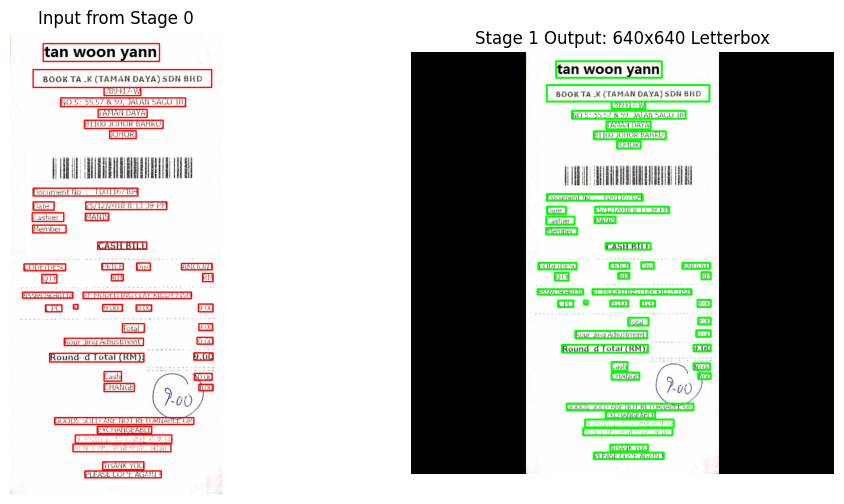

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
def preprocess_image_and_labels(image, polygons, target_size=640):
    """
    Step 1: Resizes the image to a square canvas using letterbox padding.
    Step 2: Adjusts polygon coordinates mathematically.
    Step 3: Normalizes the image to a PyTorch Tensor [0, 1].
    """
    h, w = image.shape[:2]

    #  Scale Calculation
    max_side = max(h, w)
    ratio = target_size / max_side

    new_w = int(w * ratio)
    new_h = int(h * ratio)

    # Resize the raw image keeping its aspect ratio intact
    resized_img = cv2.resize(image, (new_w, new_h))

    # Padding (The Letterbox Canvas)
    # Create a completely black square canvas (640x640)
    canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # Calculate exact padding to center the resized image
    pad_w = (target_size - new_w) // 2
    pad_h = (target_size - new_h) // 2

    # Paste the resized image right into the middle of the black canvas
    canvas[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized_img

    #  Adjust Polygons to match the new canvas
    adjusted_polygons = []
    for poly in polygons:
        new_poly = np.zeros_like(poly, dtype=np.float32)
        # Multiply by ratio, then shift by the padding amount
        new_poly[:, 0] = poly[:, 0] * ratio + pad_w
        new_poly[:, 1] = poly[:, 1] * ratio + pad_h
        adjusted_polygons.append(new_poly.astype(np.int32))

    #  Normalize & Convert to PyTorch Tensor
    # Convert pixels from [0, 255] to [0.0, 1.0]
    normalized_img = canvas.astype(np.float32) / 255.0

    # PyTorch expects channels first: (Channels, Height, Width) -> [3, 640, 640]
    img_tensor = torch.from_numpy(normalized_img).permute(2, 0, 1)

    return img_tensor, adjusted_polygons, ratio, (pad_w, pad_h), canvas
try:
    img_tensor, final_polys, ratio, padding, canvas_img = preprocess_image_and_labels(
        cropped_img,
        cropped_polys,
        target_size=640
    )
    print(f"Original Image Shape: {cropped_img.shape}")
    print(f"Calculated Ratio:     {ratio:.4f}")
    print(f"Padding added (W, H): {padding}")
    print(f"Final Tensor Shape:   {img_tensor.shape}")
    print("-" * 27)

    # Plotting to verify math is correct
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(draw_polygons(cropped_img, cropped_polys, color=(255, 0, 0)))
    plt.title("Input from Stage 0")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(draw_polygons(canvas_img, final_polys, color=(0, 255, 0)))
    plt.title("Stage 1 Output: 640x640 Letterbox")
    plt.axis('off')

    plt.show()

except NameError:
    print("Error: 'cropped_img' not found. Please run the Stage 0 cells first!")

In [ ]:
##Creata class dataset for model

In [ ]:
import os
import glob
import random
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
class SROIEDataset_Full(Dataset):
    def __init__(self, image_dir, target_size=640, is_training=True):
        self.image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
        self.target_size = target_size
        self.is_training = is_training #sdo if this line fail i wil skip auguament

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        txt_path = img_path.replace('.jpg', '.txt')

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        polygons = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) >= 9:
                        coords = [int(p) for p in parts[:8]]
                        polygons.append(np.array(coords).reshape(4, 2))

        if self.is_training:
            img_rgb = random_photometric(img_rgb)
            img_rgb, polygons = safe_random_crop(img_rgb, polygons, crop_size=(640, 640))
            img_rgb, polygons = random_rotate(img_rgb, polygons, max_angle=10)
        img_tensor, adjusted_polys, ratio, padding, canvas = preprocess_image_and_labels(
            img_rgb, polygons, self.target_size
        )
        prob_map = generate_probability_map((self.target_size, self.target_size), adjusted_polys)
        target_tensor = torch.from_numpy(prob_map).unsqueeze(0) # Shape: [1, 640, 640]

        return img_tensor, target_tensor
try:
    print("Initializing DataLoader...")
    DATA_DIR = '/content/drive/MyDrive/0325updated.task1train(626p)'

    # We use batch_size=2 to test how DataLoader stacks images
    train_dataset = SROIEDataset_Full(DATA_DIR, target_size=640, is_training=True)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    # Fetch one batch
    images, targets = next(iter(train_loader))
    print(f"Batch Images Shape: {images.shape}")   # Expected: [2, 3, 640, 640]
    print(f"Batch Targets Shape: {targets.shape}") # Expected: [2, 1, 640, 640]
    print("DataLoader is Ready!")
except Exception as e:
    print(f"Setup Info: {e}. (Make sure to point DATA_DIR to a valid folder with images/txt)")

Initializing DataLoader...
Batch Images Shape: torch.Size([2, 3, 640, 640])
Batch Targets Shape: torch.Size([2, 1, 640, 640])
DataLoader is Ready!


In [ ]:
#DBnet architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
class DBNet_Architecture(nn.Module):
    def __init__(self):
        super(DBNet_Architecture, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.stage1 = nn.Sequential(*list(resnet.children())[:5])  # 1/4 scale
        self.stage2 = resnet.layer2                                # 1/8 scale
        self.stage3 = resnet.layer3                                # 1/16 scale
        self.stage4 = resnet.layer4                                # 1/32 scale

        #  NECK (Feature Pyramid Network - FPN)
        # Standardize the channel dimensions to 256
        self.in4 = nn.Conv2d(512, 256, kernel_size=1)
        self.in3 = nn.Conv2d(256, 256, kernel_size=1)
        self.in2 = nn.Conv2d(128, 256, kernel_size=1)
        self.in1 = nn.Conv2d(64,  256, kernel_size=1)

        # Smooth layers after upsampling
        self.out4 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.out3 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.out2 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.out1 = nn.Conv2d(256, 64, kernel_size=3, padding=1)

        #  HEAD (Probability Map Prediction)
        # Combines the 4 scales (64 * 4 = 256 channels) into a single map
        self.prob_head = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Upsample back to 1/1 scale (original size)
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid() # Squashes output between 0.0 (Black/BG) and 1.0 (White/Text)
        )

    def forward(self, x):
        # Backbone Forward
        c1 = self.stage1(x)
        c2 = self.stage2(c1)
        c3 = self.stage3(c2)
        c4 = self.stage4(c3)

        # Neck Forward (Top-Down Pathway)
        p4 = self.in4(c4)
        p3 = self.in3(c3) + F.interpolate(p4, scale_factor=2, mode='nearest')
        p2 = self.in2(c2) + F.interpolate(p3, scale_factor=2, mode='nearest')
        p1 = self.in1(c1) + F.interpolate(p2, scale_factor=2, mode='nearest')

        # Smooth the upsampled maps
        f4 = self.out4(p4)
        f3 = self.out3(p3)
        f2 = self.out2(p2)
        f1 = self.out1(p1)

        # Concatenate all scales together
        f4 = F.interpolate(f4, scale_factor=8, mode='nearest')
        f3 = F.interpolate(f3, scale_factor=4, mode='nearest')
        f2 = F.interpolate(f2, scale_factor=2, mode='nearest')
        fuse = torch.cat((f1, f2, f3, f4), dim=1) # Shape: [batch, 256, H/4, W/4]

        # Head Forward
        prob_map = self.prob_head(fuse) # Shape: [batch, 1, H, W]

        return prob_map

print("DBNet Architecture Compiled Successfully!")

DBNet Architecture Compiled Successfully!


In [ ]:
#Model Inference

Testing Inference on: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


Input Image Shape:  torch.Size([1, 3, 640, 640])
Output Map Shape:   torch.Size([1, 1, 640, 640])


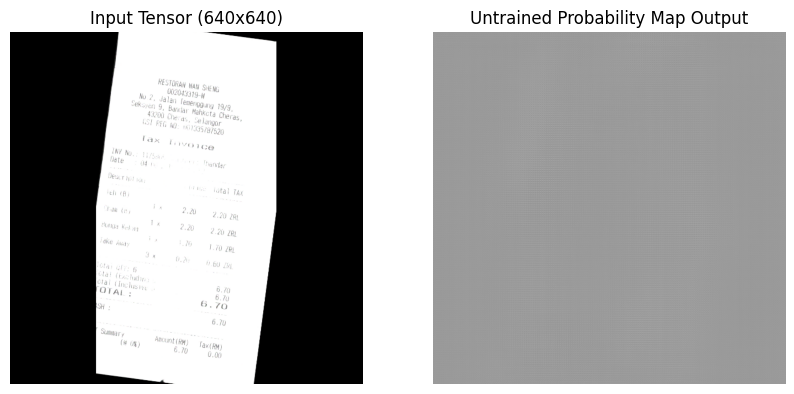

In [ ]:

try:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Testing Inference on: {device}")

    model = DBNet_Architecture().to(device)
    model.eval() # Set to evaluation mode

    # 2. Grab a dummy image tensor from our DataLoader
    # images shape is [2, 3, 640, 640]. We just take the first one and add batch dimension back
    test_input = images[0].unsqueeze(0).to(device)

    # 3. Model Inference (Forward Pass)
    with torch.no_grad():
        predicted_prob_map = model(test_input)

    print(f"Input Image Shape:  {test_input.shape}")
    print(f"Output Map Shape:   {predicted_prob_map.shape}")

    # 4. Visualize the raw output
    # Move to CPU, remove batch & channel dimensions
    prob_map_numpy = predicted_prob_map.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    # Undo normalization just for viewing the input
    view_img = test_input.squeeze().cpu().permute(1, 2, 0).numpy()
    plt.imshow(view_img)
    plt.title("Input Tensor (640x640)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # This will look like random noise because the model hasn't been trained yet!
    plt.imshow(prob_map_numpy, cmap='gray', vmin=0, vmax=1)
    plt.title("Untrained Probability Map Output")
    plt.axis('off')

    plt.show()

except NameError:
    print("Please make sure DataLoader is initialized in Cell 1.")

In [ ]:
#Post processing

In [ ]:
##POLYGON EXPANSION

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def expand_polygon(polygon_coords, expand_ratio=1.5):
    """
    Expands a compact polygon back to its full text boundary using Vatti clipping logic.
    Formula for expansion distance: D' = Area' * expand_ratio / Perimeter'
    """
    poly = Polygon(polygon_coords)

    #  Check validity
    if not poly.is_valid or poly.area == 0 or poly.length == 0:
        return polygon_coords

    #  Calculate the expansion distance D'
    distance = poly.area * expand_ratio / poly.length

    # Expand the polygon (positive distance pushes boundaries outward)
    expanded_poly = poly.buffer(distance)

    #  Extract new coordinates safely
    if expanded_poly.is_empty:
        return polygon_coords

    if expanded_poly.geom_type == 'Polygon':
        new_coords = np.array(expanded_poly.exterior.coords[:-1])
    elif expanded_poly.geom_type == 'MultiPolygon':
        # If expansion splits or creates weird shapes, take the largest one
        largest = max(expanded_poly.geoms, key=lambda p: p.area)
        new_coords = np.array(largest.exterior.coords[:-1])
    else:
        new_coords = polygon_coords

    # Convert back to a strict 4-point bounding box (minAreaRect)
    # Because expansion curves the corners, we need to box it up again.
    rect = cv2.minAreaRect(new_coords.astype(np.float32))
    final_4pt_box = cv2.boxPoints(rect)

    return final_4pt_box

print("Polygon Expansion Utility Ready!")

Polygon Expansion Utility Ready!


In [ ]:
def postprocess_dbnet(prob_map, ratio, padding, threshold=0.3, expand_ratio=1.5):
    """
    Converts the 640x640 Probability Map back into Real Coordinates on the Original Image.
    """
    #  Binarization
    prob_map_8bit = (prob_map * 255).astype(np.uint8)
    _, binary_map = cv2.threshold(prob_map_8bit, int(threshold * 255), 255, cv2.THRESH_BINARY)

    #  Find Contours
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_boxes = []
    pad_w, pad_h = padding

    for cnt in contours:
        # Ignore random noise pixels
        if cv2.contourArea(cnt) < 10:
            continue

        # Get the bounding box of the compact core
        rect = cv2.minAreaRect(cnt)
        box_model = cv2.boxPoints(rect) # Coordinates on 640x640 canvas

        #  Expand Polygon (Replacing Dilation)
        expanded_box = expand_polygon(box_model, expand_ratio)

        #  Un-scale (Mathematical Correction)
        # Shift back by padding
        expanded_box[:, 0] = expanded_box[:, 0] - pad_w
        expanded_box[:, 1] = expanded_box[:, 1] - pad_h

        # Scale back to original resolution
        expanded_box[:, 0] = expanded_box[:, 0] / ratio
        expanded_box[:, 1] = expanded_box[:, 1] / ratio

        final_boxes.append(expanded_box.astype(np.int32))

    return final_boxes, binary_map

print("Full Post-Processor Ready!")

Full Post-Processor Ready!


Original Core Box on 640 canvas:   w=100, h=20
Calculated Ratio used:             0.631786771964462
Padding used (pad_w, pad_h):       (0, 5)
Recovered Box Coordinates on 2000x1000 image:
[[652 518]
 [455 518]
 [455 447]
 [652 447]]


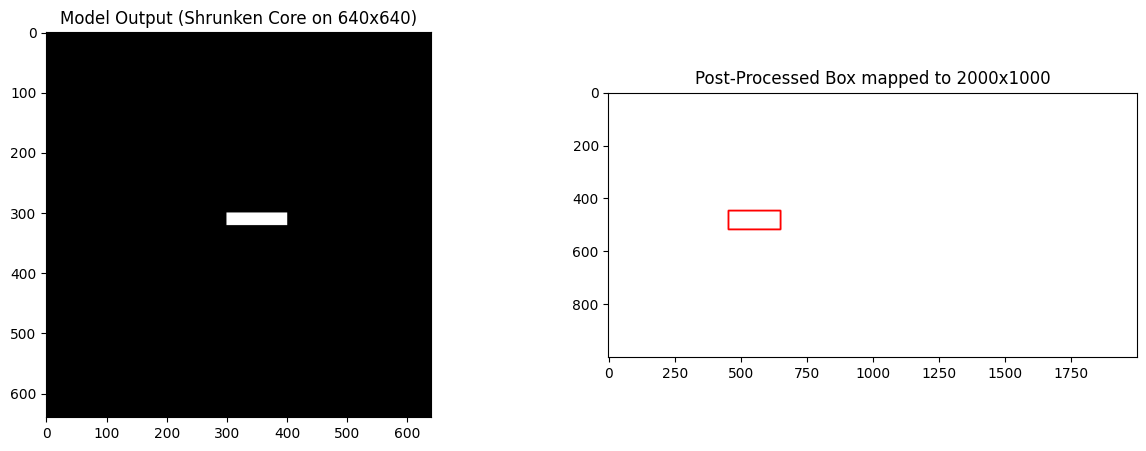

In [ ]:

fake_orig_w, fake_orig_h = 2000, 1000
fake_ratio = 640 / 1013
fake_pad_w = 0
fake_pad_h = (640 - int(1000 * 0.63)) // 2 # 160

# Create a dummy Probability Map (640x640)
# All black background
dummy_prob_map = np.zeros((640, 640), dtype=np.float32)

cv2.rectangle(dummy_prob_map, (300, 300), (400, 320), 1.0, -1)

# Run it through our newly built Post-Processor
recovered_boxes, binary_map = postprocess_dbnet(
    prob_map=dummy_prob_map,
    ratio=fake_ratio,
    padding=(fake_pad_w, fake_pad_h),
    threshold=0.3,
    expand_ratio=1.5
)

#  Visualize
print(f"Original Core Box on 640 canvas:   w=100, h=20")
print(f"Calculated Ratio used:             {fake_ratio}")
print(f"Padding used (pad_w, pad_h):       ({fake_pad_w}, {fake_pad_h})")

if len(recovered_boxes) > 0:
    box = recovered_boxes[0]
    print(f"Recovered Box Coordinates on {fake_orig_w}x{fake_orig_h} image:")
    print(box)

    # Draw it on a fake blank original image
    fake_orig_img = np.ones((fake_orig_h, fake_orig_w, 3), dtype=np.uint8) * 255
    cv2.polylines(fake_orig_img, [box], isClosed=True, color=(255, 0, 0), thickness=5)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(dummy_prob_map, cmap='gray')
    plt.title("Model Output (Shrunken Core on 640x640)")

    plt.subplot(1, 2, 2)
    plt.imshow(fake_orig_img)
    plt.title(f"Post-Processed Box mapped to {fake_orig_w}x{fake_orig_h}")

    plt.show()
else:
    print("No boxes recovered!")

In [ ]:
#training model

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
def train_dbnet_with_metrics(model, train_loader, num_epochs=50, lr=1e-4, save_dir='./models'):
    """
    Enhanced training loop calculating Pixel-level Precision, Recall, and H-Mean.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[*] Starting Training on Device: {device}")

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_TP = 0.0
        total_FP = 0.0
        total_FN = 0.0

        start_time = time.time()

        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            with torch.no_grad():
                # Binarize predictions and targets (Threshold = 0.3)
                preds_binary = (predictions > 0.3).float()
                targets_binary = (targets > 0.5).float()

                # True Positives: Model said 1, Target is 1
                TP = (preds_binary * targets_binary).sum().item()
                # False Positives: Model said 1, Target is 0 (Ghost text)
                FP = (preds_binary * (1.0 - targets_binary)).sum().item()
                # False Negatives: Model said 0, Target is 1 (Missed text)
                FN = ((1.0 - preds_binary) * targets_binary).sum().item()

                total_TP += TP
                total_FP += FP
                total_FN += FN
        avg_loss = epoch_loss / len(train_loader)
        time_taken = time.time() - start_time

        # Calculate Precision, Recall, and H-Mean (with a tiny epsilon to prevent division by zero)
        epsilon = 1e-6
        precision = total_TP / (total_TP + total_FP + epsilon)
        recall = total_TP / (total_TP + total_FN + epsilon)
        h_mean = 2 * precision * recall / (precision + recall + epsilon)

        # Clean and Professional Console Output
        print(f"Epoch [{epoch+1:02d}/{num_epochs}] | Loss: {avg_loss:.4f} | Prec: {precision*100:.1f}% | Rec: {recall*100:.1f}% | H-Mean: {h_mean*100:.1f}% | Time: {time_taken:.1f}s")
        if avg_loss < best_loss:
            best_loss = avg_loss
            save_path = os.path.join(save_dir, 'best_dbnet_model_last.pth')

            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': best_loss,
                'h_mean': h_mean
            }, save_path)

            print(f"    -> [SAVE] New Best Model! Loss dropped to {best_loss:.4f}")

    print("[*] Training Completed Successfully!")
    return model

In [ ]:
try:
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 4

    # Initialize Dataset and DataLoader
    train_dataset = SROIEDataset_Full(DATA_DIR, target_size=640, is_training=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    # Initialize Model
    dbnet_model = DBNet_Architecture()

    # START TRAINING!
    print("Initializing Data Pipeline...")
    trained_model = train_dbnet_with_metrics(
        model=dbnet_model,
        train_loader=train_loader,
        num_epochs=EPOCHS,
        lr=LEARNING_RATE,
        save_dir='/content/drive/MyDrive/My_New_Models'
    )

except Exception as e:
    print(f"Execution Error: {e}")

Initializing Data Pipeline...
[*] Starting Training on Device: cuda
Epoch [01/50] | Loss: 0.2894 | Prec: 15.2% | Rec: 87.4% | H-Mean: 25.9% | Time: 217.5s
    -> [SAVE] New Best Model! Loss dropped to 0.2894
Epoch [02/50] | Loss: 0.1443 | Prec: 52.1% | Rec: 89.2% | H-Mean: 65.8% | Time: 53.3s
    -> [SAVE] New Best Model! Loss dropped to 0.1443
Epoch [03/50] | Loss: 0.1127 | Prec: 60.4% | Rec: 88.7% | H-Mean: 71.9% | Time: 53.2s
    -> [SAVE] New Best Model! Loss dropped to 0.1127
Epoch [04/50] | Loss: 0.0922 | Prec: 65.5% | Rec: 88.0% | H-Mean: 75.1% | Time: 57.5s
    -> [SAVE] New Best Model! Loss dropped to 0.0922
Epoch [05/50] | Loss: 0.0819 | Prec: 66.8% | Rec: 87.7% | H-Mean: 75.9% | Time: 55.3s
    -> [SAVE] New Best Model! Loss dropped to 0.0819
Epoch [06/50] | Loss: 0.0719 | Prec: 69.1% | Rec: 87.2% | H-Mean: 77.1% | Time: 57.0s
    -> [SAVE] New Best Model! Loss dropped to 0.0719
Epoch [07/50] | Loss: 0.0639 | Prec: 70.2% | Rec: 87.1% | H-Mean: 77.7% | Time: 49.2s
    -> [SAV

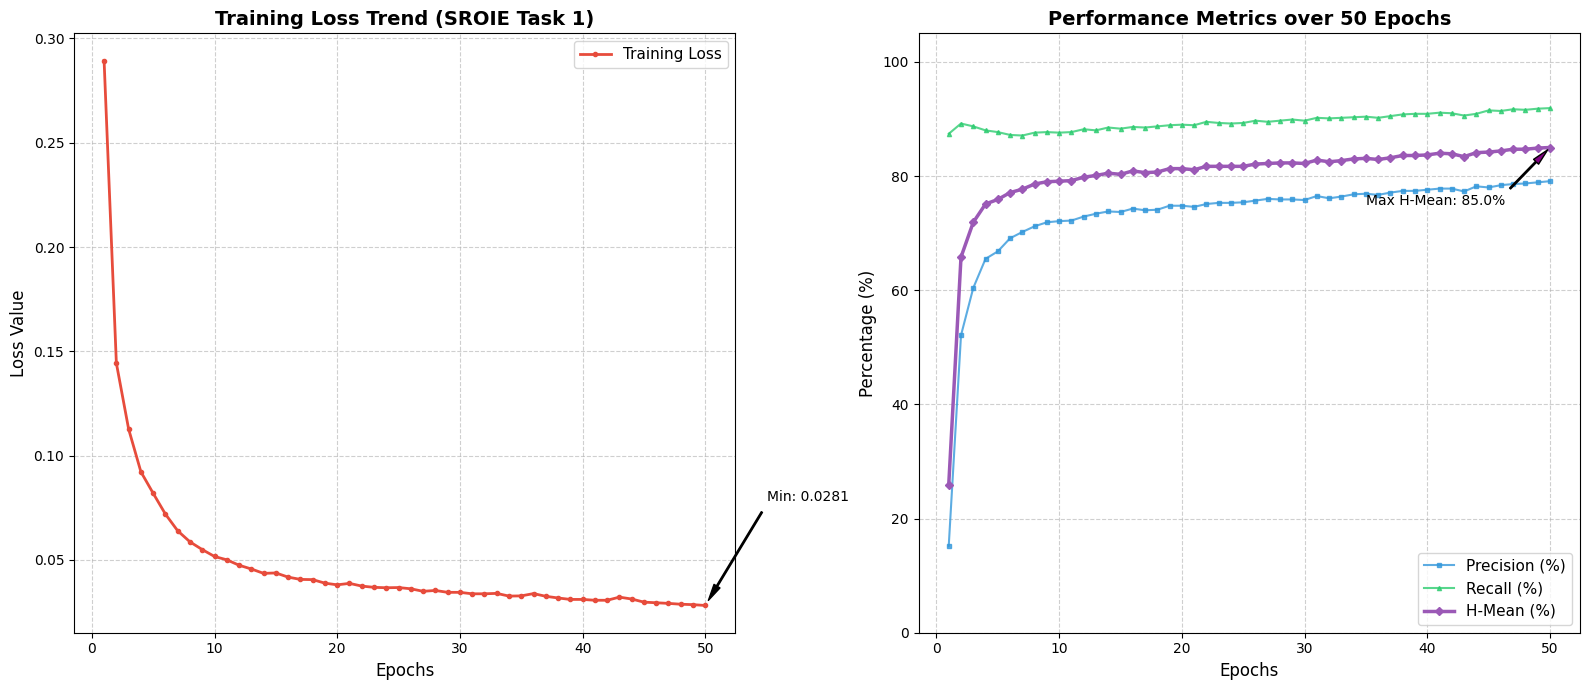

[*] Biểu đồ đã được vẽ dựa trên 50 Epochs.


In [8]:
import re
import matplotlib.pyplot as plt
log_text = """
Epoch [01/50] | Loss: 0.2894 | Prec: 15.2% | Rec: 87.4% | H-Mean: 25.9% | Time: 217.5s
Epoch [02/50] | Loss: 0.1443 | Prec: 52.1% | Rec: 89.2% | H-Mean: 65.8% | Time: 53.3s
Epoch [03/50] | Loss: 0.1127 | Prec: 60.4% | Rec: 88.7% | H-Mean: 71.9% | Time: 53.2s
Epoch [04/50] | Loss: 0.0922 | Prec: 65.5% | Rec: 88.0% | H-Mean: 75.1% | Time: 57.5s
Epoch [05/50] | Loss: 0.0819 | Prec: 66.8% | Rec: 87.7% | H-Mean: 75.9% | Time: 55.3s
Epoch [06/50] | Loss: 0.0719 | Prec: 69.1% | Rec: 87.2% | H-Mean: 77.1% | Time: 57.0s
Epoch [07/50] | Loss: 0.0639 | Prec: 70.2% | Rec: 87.1% | H-Mean: 77.7% | Time: 49.2s
Epoch [08/50] | Loss: 0.0586 | Prec: 71.2% | Rec: 87.6% | H-Mean: 78.6% | Time: 56.9s
Epoch [09/50] | Loss: 0.0549 | Prec: 71.9% | Rec: 87.7% | H-Mean: 79.0% | Time: 62.4s
Epoch [10/50] | Loss: 0.0516 | Prec: 72.1% | Rec: 87.6% | H-Mean: 79.1% | Time: 60.0s
Epoch [11/50] | Loss: 0.0500 | Prec: 72.2% | Rec: 87.7% | H-Mean: 79.2% | Time: 56.8s
Epoch [12/50] | Loss: 0.0474 | Prec: 72.9% | Rec: 88.2% | H-Mean: 79.8% | Time: 60.0s
Epoch [13/50] | Loss: 0.0456 | Prec: 73.4% | Rec: 88.0% | H-Mean: 80.1% | Time: 53.8s
Epoch [14/50] | Loss: 0.0435 | Prec: 73.8% | Rec: 88.5% | H-Mean: 80.5% | Time: 54.7s
Epoch [15/50] | Loss: 0.0437 | Prec: 73.7% | Rec: 88.3% | H-Mean: 80.3% | Time: 58.1s
Epoch [16/50] | Loss: 0.0417 | Prec: 74.3% | Rec: 88.6% | H-Mean: 80.9% | Time: 50.8s
Epoch [17/50] | Loss: 0.0406 | Prec: 74.0% | Rec: 88.5% | H-Mean: 80.6% | Time: 53.9s
Epoch [18/50] | Loss: 0.0405 | Prec: 74.1% | Rec: 88.7% | H-Mean: 80.7% | Time: 62.0s
Epoch [19/50] | Loss: 0.0388 | Prec: 74.8% | Rec: 88.9% | H-Mean: 81.3% | Time: 58.1s
Epoch [20/50] | Loss: 0.0380 | Prec: 74.8% | Rec: 89.0% | H-Mean: 81.3% | Time: 61.3s
Epoch [21/50] | Loss: 0.0387 | Prec: 74.6% | Rec: 88.9% | H-Mean: 81.1% | Time: 57.3s
Epoch [22/50] | Loss: 0.0374 | Prec: 75.1% | Rec: 89.5% | H-Mean: 81.7% | Time: 58.2s
Epoch [23/50] | Loss: 0.0368 | Prec: 75.3% | Rec: 89.3% | H-Mean: 81.7% | Time: 57.5s
Epoch [24/50] | Loss: 0.0366 | Prec: 75.3% | Rec: 89.2% | H-Mean: 81.7% | Time: 56.7s
Epoch [25/50] | Loss: 0.0367 | Prec: 75.4% | Rec: 89.3% | H-Mean: 81.7% | Time: 56.5s
Epoch [26/50] | Loss: 0.0361 | Prec: 75.7% | Rec: 89.7% | H-Mean: 82.1% | Time: 48.6s
Epoch [27/50] | Loss: 0.0349 | Prec: 76.0% | Rec: 89.5% | H-Mean: 82.2% | Time: 55.7s
Epoch [28/50] | Loss: 0.0353 | Prec: 75.9% | Rec: 89.7% | H-Mean: 82.3% | Time: 56.1s
Epoch [29/50] | Loss: 0.0344 | Prec: 75.9% | Rec: 89.9% | H-Mean: 82.3% | Time: 51.9s
Epoch [30/50] | Loss: 0.0344 | Prec: 75.8% | Rec: 89.7% | H-Mean: 82.2% | Time: 56.5s
Epoch [31/50] | Loss: 0.0337 | Prec: 76.5% | Rec: 90.2% | H-Mean: 82.8% | Time: 55.7s
Epoch [32/50] | Loss: 0.0337 | Prec: 76.1% | Rec: 90.1% | H-Mean: 82.5% | Time: 61.6s
Epoch [33/50] | Loss: 0.0339 | Prec: 76.4% | Rec: 90.2% | H-Mean: 82.7% | Time: 53.9s
Epoch [34/50] | Loss: 0.0326 | Prec: 76.8% | Rec: 90.3% | H-Mean: 83.0% | Time: 54.5s
Epoch [35/50] | Loss: 0.0327 | Prec: 76.9% | Rec: 90.4% | H-Mean: 83.1% | Time: 53.7s
Epoch [36/50] | Loss: 0.0338 | Prec: 76.7% | Rec: 90.2% | H-Mean: 82.9% | Time: 58.4s
Epoch [37/50] | Loss: 0.0325 | Prec: 77.1% | Rec: 90.5% | H-Mean: 83.2% | Time: 52.2s
Epoch [38/50] | Loss: 0.0317 | Prec: 77.4% | Rec: 90.8% | H-Mean: 83.6% | Time: 54.8s
Epoch [39/50] | Loss: 0.0310 | Prec: 77.4% | Rec: 90.9% | H-Mean: 83.6% | Time: 56.4s
Epoch [40/50] | Loss: 0.0310 | Prec: 77.6% | Rec: 90.9% | H-Mean: 83.7% | Time: 55.9s
Epoch [41/50] | Loss: 0.0306 | Prec: 77.8% | Rec: 91.1% | H-Mean: 84.0% | Time: 53.9s
Epoch [42/50] | Loss: 0.0306 | Prec: 77.8% | Rec: 91.0% | H-Mean: 83.9% | Time: 60.9s
Epoch [43/50] | Loss: 0.0321 | Prec: 77.3% | Rec: 90.6% | H-Mean: 83.4% | Time: 59.3s
Epoch [44/50] | Loss: 0.0312 | Prec: 78.2% | Rec: 90.9% | H-Mean: 84.1% | Time: 54.8s
Epoch [45/50] | Loss: 0.0297 | Prec: 78.0% | Rec: 91.5% | H-Mean: 84.2% | Time: 55.4s
Epoch [46/50] | Loss: 0.0294 | Prec: 78.4% | Rec: 91.4% | H-Mean: 84.4% | Time: 55.5s
Epoch [47/50] | Loss: 0.0291 | Prec: 78.6% | Rec: 91.7% | H-Mean: 84.7% | Time: 62.4s
Epoch [48/50] | Loss: 0.0287 | Prec: 78.7% | Rec: 91.6% | H-Mean: 84.7% | Time: 59.1s
Epoch [49/50] | Loss: 0.0285 | Prec: 78.9% | Rec: 91.8% | H-Mean: 84.9% | Time: 56.5s
Epoch [50/50] | Loss: 0.0281 | Prec: 79.1% | Rec: 91.9% | H-Mean: 85.0% | Time: 60.0s
"""

epochs, losses, precs, recs, h_means = [], [], [], [], []
pattern = r"Epoch \[(\d+)/\d+\] \| Loss: ([\d.]+) \| Prec: ([\d.]+)% \| Rec: ([\d.]+)% \| H-Mean: ([\d.]+)%"

for line in log_text.strip().split('\n'):
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        losses.append(float(match.group(2)))
        precs.append(float(match.group(3)))
        recs.append(float(match.group(4)))
        h_means.append(float(match.group(5)))

#plots
plt.figure(figsize=(16, 7))

# Loss Cruve
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', markersize=3, color='#e74c3c', linewidth=2, label='Training Loss')
# Loss min
min_loss = min(losses)
min_epoch = epochs[losses.index(min_loss)]
plt.annotate(f'Min: {min_loss:.4f}', xy=(min_epoch, min_loss), xytext=(min_epoch+5, min_loss+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.title('Training Loss Trend (SROIE Task 1)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)

#  Evaluation
plt.subplot(1, 2, 2)
plt.plot(epochs, precs, marker='s', markersize=3, color='#3498db', alpha=0.8, label='Precision (%)')
plt.plot(epochs, recs, marker='^', markersize=3, color='#2ecc71', alpha=0.8, label='Recall (%)')
plt.plot(epochs, h_means, marker='D', markersize=4, color='#9b59b6', linewidth=2.5, label='H-Mean (%)')

# MAx H-mean
max_h = max(h_means)
max_h_epoch = epochs[h_means.index(max_h)]
plt.annotate(f'Max H-Mean: {max_h}%', xy=(max_h_epoch, max_h), xytext=(max_h_epoch-15, max_h-10),
             arrowprops=dict(facecolor='purple', shrink=0.05, width=1, headwidth=5))

plt.title('Performance Metrics over 50 Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig('training_result_final.png', dpi=300)
plt.show()






[*] Loading model from: /content/drive/MyDrive/My_New_Models/best_dbnet_model_last.pth
[*] Model loaded! (Best H-Mean achieved: 85.04%)


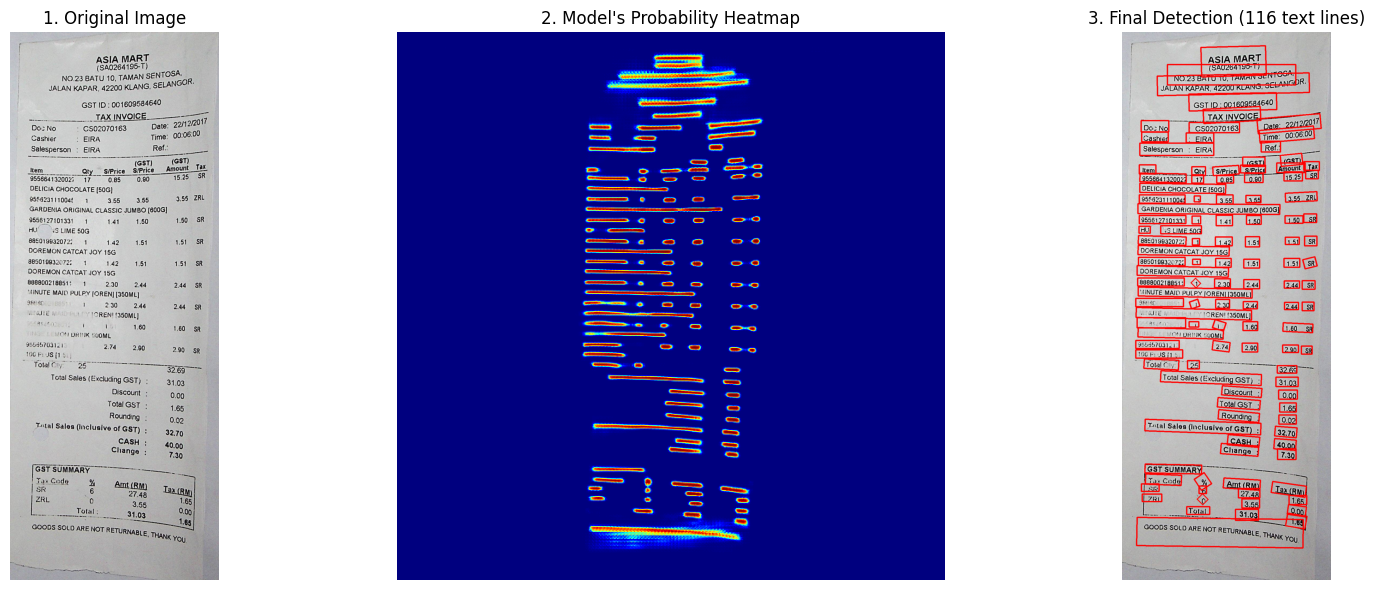

In [ ]:
import os
import random
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def preprocess_for_inference(image, target_size=640):
    """Prepares a raw image for the model without needing text polygons."""
    h, w = image.shape[:2]
    ratio = target_size / max(h, w)
    new_w, new_h = int(w * ratio), int(h * ratio)

    resized_img = cv2.resize(image, (new_w, new_h))
    canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    pad_w = (target_size - new_w) // 2
    pad_h = (target_size - new_h) // 2
    canvas[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized_img

    normalized_img = canvas.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(normalized_img).permute(2, 0, 1).unsqueeze(0)

    return img_tensor, ratio, (pad_w, pad_h)

def test_final_model(image_path, weight_path, device_name='cuda'):
    device = torch.device(device_name if torch.cuda.is_available() else 'cpu')
    print(f"[*] Loading model from: {weight_path}")

    #  Load Model
    model = DBNet_Architecture().to(device)
    checkpoint = torch.load(weight_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print(f"[*] Model loaded! (Best H-Mean achieved: {checkpoint.get('h_mean', 0)*100:.2f}%)")

    # Load & Preprocess Image
    orig_img = cv2.imread(image_path)
    if orig_img is None:
        print("Image not found!")
        return

    img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    input_tensor, ratio, padding = preprocess_for_inference(img_rgb)

    # prediction of model
    with torch.no_grad():
        preds = model(input_tensor.to(device))
    prob_map = preds.squeeze().cpu().numpy()

    # Post-processing (The magic mathematical expansion we built)
    # Using threshold 0.3 and expand_ratio 1.5 as standard for DBNet
    final_boxes, binary_map = postprocess_dbnet(prob_map, ratio, padding, threshold=0.3, expand_ratio=1.5)

    #  result
    result_img = img_rgb.copy()
    for box in final_boxes:
        # Draw thick red bounding polygons
        cv2.polylines(result_img, [box], isClosed=True, color=(255, 0, 0), thickness=3)

    # plots
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("1. Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prob_map, cmap='jet') # Heatmap visualization
    plt.title("2. Model's Probability Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_img)
    plt.title(f"3. Final Detection ({len(final_boxes)} text lines)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

#test
test_images = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
random_test_img = random.choice(test_images)

BEST_WEIGHT_PATH = '/content/drive/MyDrive/My_New_Models/best_dbnet_model_last.pth'

test_final_model(random_test_img, BEST_WEIGHT_PATH)

[*] Processing external image: /content/drive/MyDrive/0325updated.task1train(626p)/X00016469669.jpg
[*] Loading model from: /content/drive/MyDrive/My_New_Models/best_dbnet_model_last.pth
[*] Model loaded! (Best H-Mean achieved: 85.04%)


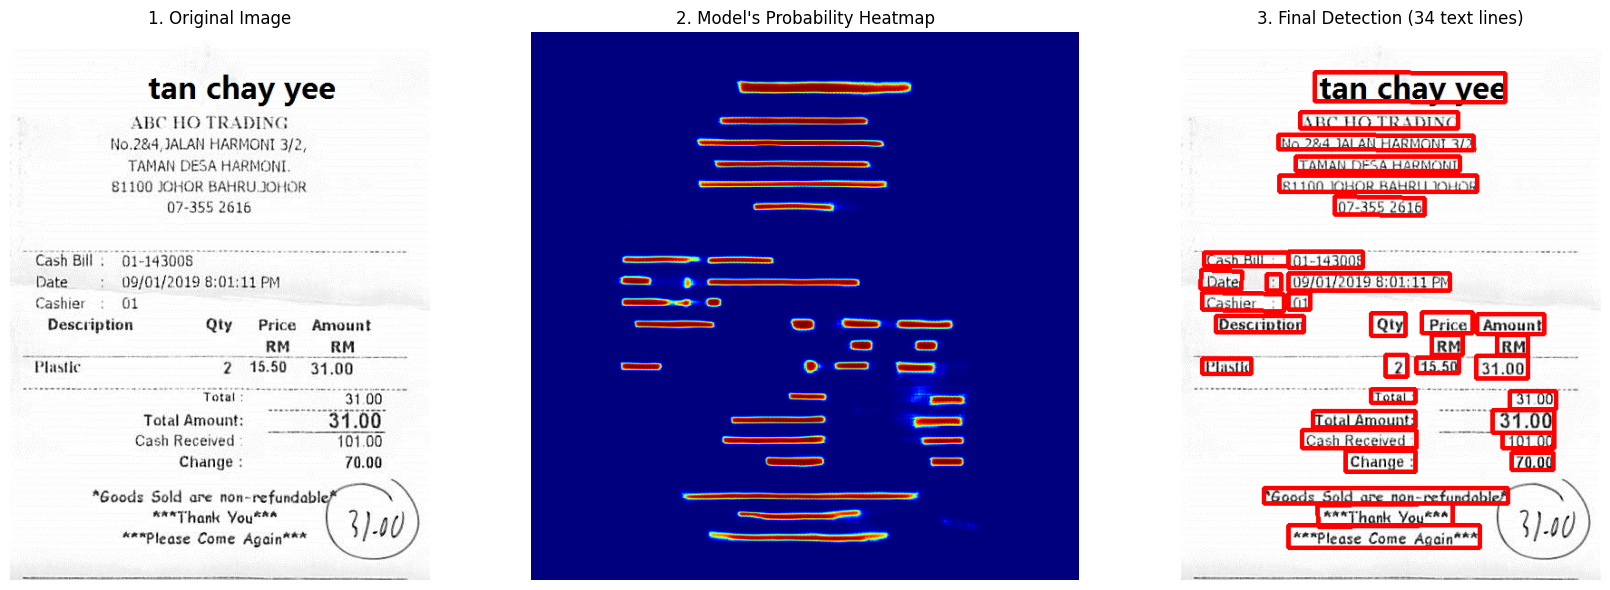

In [ ]:
import os

def test_external_image(image_path, weight_path):
    """
    Runs inference on an arbitrary uploaded image using our trained DBNet.
    """
    if not os.path.exists(image_path):
        print(f"not found at path '{image_path}'")
        print("okay ?")
        return

    print(f"[*] Processing external image: {image_path}")

    try:
        test_final_model(image_path, weight_path)
    except NameError:
        print("[!] Error: Function 'test_final_model' not found.")
        print("Please run the cell for Stage 5 (The Final Inference Pipeline) above first.")

CUSTOM_IMAGE_PATH = '/content/drive/MyDrive/0325updated.task1train(626p)/X00016469669.jpg'

BEST_WEIGHT_PATH = '/content/drive/MyDrive/My_New_Models/best_dbnet_model_last.pth'

#test

test_external_image(CUSTOM_IMAGE_PATH, BEST_WEIGHT_PATH)
